In [ ]:
for i in range(10):
    start_time = time.time()
    envs = [lambda: gym.make('CartPole-v0') for x in range(1)]
    venv = ParallelEnvironment(envs)
    agent = PPOAgent(venv, buffer_size=64)
    agent.run(50)
    print("{:.3f}".format(time.time() - start_time))

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [ ]:
import threading
from IPython.display import display
import ipywidgets as widgets
from sidecar import Sidecar

In [ ]:
run_dir = "./runs/agent-27/data/"
line_limit = 10
log_path = run_dir + 'agent.txt'
log_val = []
kill_thread = False
last_frame_count = 0
empty_frame_count = 0

def update_log():
    log_val = ['<li><code style="font-size: 10px;">{}</code></li>'.format(line) for 
               line in list(open(log_path))[-line_limit:]]
    log_widget.value = '<ul style="list-style-type: none; padding: 0;">' + ''.join(log_val) + '</ul>'
    
def on_change(x):
    if (x['name'] == 'value'):
        update_image(x['new'])
        
def kill_thread_click(x):
    global kill_thread
    kill_thread = True
        
def live_update():
    global last_frame_count
    global empty_frame_count
    while True:
        update_count_widget.value = "Last Update: " + time.strftime('%c')
        update_log()
        if last_frame_count == frame_count:
            empty_frame_count += 1
        else:
            last_frame_count = frame_count
            empty_frame_count = 0
        if empty_frame_count > 10 or kill_thread:
            update_count_widget.value = 'Halted: ' + time.strftime('%c')
            break
        time.sleep(1)

play_widget = widgets.Play(
    interval=250,
    value=frame_count,
    min=0,
    max=frame_count,
    step=1,
    description="Press play",
    disabled=False
)
slider_widget = widgets.IntSlider(max=frame_count)
image_widget = widgets.Image(format='png', height=100)
 
slider_widget.observe(on_change)
widgets.jslink((play_widget, 'value'), (slider_widget, 'value'))

log_widget = widgets.HTML()

update_count_widget = widgets.Label()

kill_button_widget = widgets.Button(
    description='Kill Thread'
)
kill_button_widget.on_click(kill_thread_click)

thread = threading.Thread(target=live_update)
thread.start()

training_info = widgets.VBox([image_widget,
                      widgets.HBox([kill_button_widget, play_widget, slider_widget, update_count_widget]),
                      log_widget])

sc = Sidecar(title='Training Info')
with sc:
    display(training_info)

## ZeroMQ

In [ ]:
import zmq

In [ ]:
context = zmq.Context()
with context.socket(zmq.REQ) as socket:
    socket.connect('tcp://127.0.0.1:5555')
    socket.send_string('zeromq')
    msg = socket.recv()
    print(msg)

# Logging

In [1]:
%load_ext autoreload
%autoreload 2
from MarkovDecisionProcess import MarkovDecisionProcess
import numpy as np
import time
import json

In [2]:
mdp = MarkovDecisionProcess(overwrite=True)

In [174]:
mdp.create_log_dir()

In [175]:
logger = mdp.setup_logger("test")

# Testing New Agent

In [557]:
%load_ext autoreload
%autoreload 2
from Agent import Agent
from ParallelEnvironment import ParallelEnvironment
import gym
import time
import numpy as np
import matplotlib.pyplot as plt
import logging

import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
tf.enable_eager_execution(config=config)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Critic Model

In [558]:
from Agent import CriticModel

In [559]:
input_data = np.array([
    [0, 0],
    [0, 1],
    [1, 0],
    [1, 1]
])

output_data = np.array([
    [0],
    [1],
    [1],
    [0]
])

critic = CriticModel(len(input_data[0]), len(output_data[0]))

In [562]:
for i in range(100):
    with tf.GradientTape() as tape:
        values = critic(input_data)
        critic_loss = -tf.reduce_sum((output_data - values)**2)

    critic_grad_tensors = tape.gradient(critic_loss, critic.trainable_weights)
    critic_grads = [g.numpy() for g in critic_grad_tensors]
    
    for w, cg in zip(critic.trainable_weights, critic_grads):
        w.assign_add(0.01 * np.array(cg))
        
print(critic_loss)
print(output_data)
print(values)

tf.Tensor(-0.004017717, shape=(), dtype=float32)
[[0]
 [1]
 [1]
 [0]]
tf.Tensor(
[[0.05262346]
 [0.975196  ]
 [0.9789498 ]
 [0.0137891 ]], shape=(4, 1), dtype=float32)


## Actor Model

In [563]:
from Agent import ActorModel

In [564]:
input_data = np.array([
    [0, 0],
    [0, 1],
    [1, 0],
    [1, 1]
])

output_data = np.array([
    [1, 0],
    [0, 1],
    [0, 1],
    [1, 0]
])

In [582]:
actor = ActorModel(3, 3)

DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


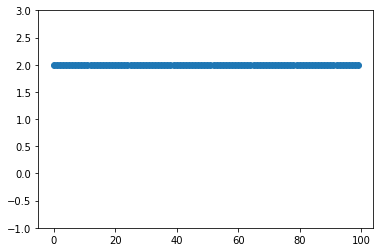

In [584]:
data = []
for i in range(100):
    state = 1 #np.random.choice(3)
    observation = [0,0,0]
    observation[state] = 1
    
    with tf.GradientTape() as tape:
        logits = actor([observation])
        probs = tf.nn.softmax(logits)
        #action = np.random.choice(3, p=probs.numpy()[0])
        action = 2
        data.append(action)
        if action == state:
            adv = 1
        else:
            adv = -1
            
        mask = np.zeros(3)
        mask[action] = adv
        actor_loss = tf.log(probs + 1e-10)*mask
        
    actor_grad_tensors = tape.gradient(actor_loss, actor.trainable_weights)
    actor_grads = [g.numpy() for g in actor_grad_tensors]
    
    for w, ag in zip(actor.trainable_weights, actor_grads):
        w.assign_add(0.01*ag)

plt.ylim(-1,3)
plt.plot(data, 'o')

DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


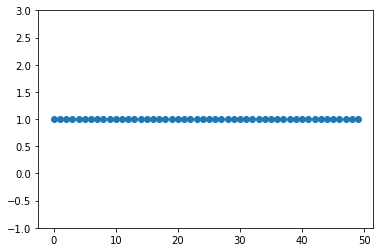

DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


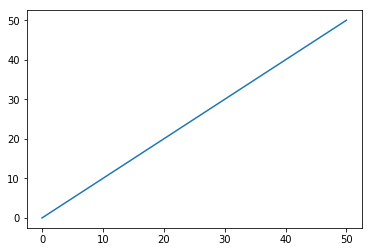

In [585]:
data = []
rews = [0]
for i in range(50):
    state = 1 #np.random.choice(3)
    observation = [0,0,0]
    observation[state] = 1
    # [1,0,0]
    
    with tf.GradientTape() as tape:
        logits = actor([observation])
        probs = tf.nn.softmax(logits)
        action = np.random.choice(3, p=probs.numpy()[0])
        data.append(action)
        if action == state:
            adv = 1
        else:
            adv = -1
            
        rews.append(adv + rews[-1])
        mask = np.zeros(3)
        mask[action] = adv
        actor_loss = tf.log(probs + 1e-10)*mask
        
    actor_grad_tensors = tape.gradient(actor_loss, actor.trainable_weights)
    actor_grads = [g.numpy() for g in actor_grad_tensors]
    
    #for w, ag in zip(actor.trainable_weights, actor_grads):
    #    w.assign_add(0.01*ag)

plt.ylim(-1,3)
plt.plot(data, 'o')
plt.show()

plt.plot(rews)

In [4]:
import plotly
import plotly.graph_objs as go

plotly.offline.init_notebook_mode(connected=True)

plotly.offline.iplot({
    "data": [go.Scatter(x=np.arange(len(data)), y=data, mode='markers')],
    "layout": go.Layout(title="Actions Taken")
})

NameError: name 'data' is not defined

In [204]:
env = gym.make('MountainCar-v0')
agent = Agent(env)
agent.train(500)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Ep: 99, Rew: -200.0
Ep: 199, Rew: -200.0
Ep: 299, Rew: -200.0
Ep: 399, Rew: -200.0
Ep: 499, Rew: -200.0


In [535]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [589]:
from Agent import ActorCriticModel

In [6]:
observations = np.array([
    [0, 0],
    [0, 1],
    [1, 0],
    [1, 1]
])

correct_action = np.array([
    [1, 0],
    [0, 1],
    [0, 1],
    [1, 0]
])

class XOREnv:
    def __init__(self, timesteps=10):
        self.action_space = gym.spaces.MultiBinary(1)
        self.observation_space = gym.spaces.Discrete(2)
        
        self.observations = np.array([
            [0, 0],
            [0, 1],
            [1, 0],
            [1, 1]
        ])
        
        self.actions = np.array([
            [1, 0],
            [0, 1],
            [0, 1],
            [1, 0]
        ])
        
        self.timesteps = timesteps

    def reset(self):
        self.timestep = 0
        self.state = np.random.choice(len(self.actions))
        return self.observations[self.state]
    
    def step(self, action):
        if action == np.argmax(self.actions[self.state]):
            reward = 1
        else:
            reward = -1
            
        self.state = np.random.choice(len(self.actions))
        
        self.timestep += 1
        if self.timestep > self.timesteps:
            done = True
        else:
            done = False
            
        if self.timestep + 1 > self.timesteps:
            last_run = True
        else:
            last_run = False
            
        return self.observations[self.state], reward, done, { "last_run": last_run }

In [7]:
class RandomAgent:
    def __init__(self, env):
        self.env = env
        
    def step(self, observation):
        return np.random.choice(self.env.action_space.n)

In [8]:
env = XOREnv()
agent = RandomAgent(env)

obs = agent.env.reset()
done = False
step = 0
rewards = []
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
while not done:
    logging.debug(f"{'step':>13}: {step}")
    action = agent.step(obs)
    logging.debug(f"{'action':>13}: {action}")
    
    next_obs, reward, done, info = agent.env.step(action)
    logging.debug(f"{'next_obs':>13}: {next_obs}")
    logging.debug(f"{'reward':>13}: {reward}")
    logging.debug(f"{'done':>13}: {done}")
    logging.debug(f"{'info':>13}: {info}")
    
    step += 1
    rewards.append(reward)
    total_reward = np.sum(rewards)
    logging.debug(f"{'total_reward':>13}: {total_reward}")
    logging.debug(f"{'...':>13}\n")
    logger.setLevel(logging.INFO)
    
logging.info(" Total Reward: {}".format(np.sum(rewards)))

AttributeError: module 'gym' has no attribute 'spaces'

In [590]:
def run_v2(env, a2c, epochs=8, verbose=0):
    gamma = 0.99
    vf_coef = 0.25
    ent_coef = 0.001
    max_grad_norm = 0.5
    learning_rate = 7e-4
    
    obs = env.reset()
    done = False
    step = 0
    rewards = []
    actions = []
    observations = []
    logger = logging.getLogger()
    logger.setLevel(logging.INFO)
    if verbose > 1:
        logger.setLevel(logging.DEBUG)
        
    while not done:
        logging.debug(f"{'step':>13}: {step}")
        logging.debug(f"{'obs':>13}: {obs}")

        logits, _ = a2c([obs])
        logging.debug(f"{'logits':>13}: {logits.numpy()[0:3]}...")

        probs = tf.nn.softmax(logits)
        logging.debug(f"{'probs':>13}: {probs[0].numpy()}")

        action = np.argmax(probs[0]) # TODO: Sample
        logging.debug(f"{'action':>13}: {action}")

        next_obs, reward, done, info = env.step(action)
        logging.debug(f"{'next_obs':>13}: {next_obs}")
        logging.debug(f"{'reward':>13}: {reward}")
        logging.debug(f"{'done':>13}: {done}")
        logging.debug(f"{'info':>13}: {info}")

        step += 1
        obs = next_obs
        
        rewards.append(reward)
        actions.append(action)
        observations.append(obs)
        
        total_reward = np.sum(rewards)
        logging.debug(f"{'total_reward':>13}: {total_reward}")
        logging.debug(f"{'...':>13}\n")
        if verbose < 2:
            logger.setLevel(logging.INFO)
            
        if done:
            rewards = np.array(rewards)
            actions = np.array(actions)
            observations = np.array(observations)
            
            futures = [0.]
            for i in range(len(rewards), 1, -1):
                futures.append(rewards[i - 1] + gamma * futures[len(rewards) - i])
            futures = np.array(futures)[::-1]
            futures -= np.mean(futures)
            futures /= np.std(futures)

            for epoch in range(epochs):
                with tf.GradientTape() as tape:
                    logits, values = a2c(observations)
                    values = tf.squeeze(values)
                    
                    logging.debug(" Actor Loss:")
                    
                    probs = tf.nn.softmax(logits)
                    logging.debug(f"{'probs':>13}: {probs[0:3].numpy()}...")

                    actions = np.argmax(probs, axis=1) # TODO: Sample
                    logging.debug(f"{'actions':>13}: {actions[0:3]}...")
                    
                    logging.debug(f"{'futures':>13}: {futures[0:3]}...")
                    logging.debug(f"{'values':>13}: {values[0:3]}...")
                    advantages = futures - values
                    logging.debug(f"{'advantages':>13}: {advantages[0:3]}...")
                    advantages = tf.convert_to_tensor(advantages, dtype=tf.float32)

                    #action_vectors = np.zeros_like(probs)
                    #for i in range(len(action_vectors)):
                    #    action_vectors[i][action] = advantages[0][i]
                        
                    #logging.debug(f"{'action_vectors':>13}: {action_vectors[0:3]}...")

                    #neglogpac = tf.log(probs + 1e-10) * action_vectors
                    #logging.debug(f"{'neglogpac':>13}: {neglogpac[0:3]}...")

                    #entropy = probs * tf.log(probs + 1e-10)
                    entropy = tf.nn.softmax_cross_entropy_with_logits_v2(labels=probs, logits=logits)
                    logging.debug(f"{'entropy':>13}: {entropy}")
                    
                    actor_loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=actions, logits=logits)
                    logging.debug(f"{'actor_loss':>13}: {actor_loss}")
                    actor_loss *= tf.stop_gradient(advantages)
                    logging.debug(f"{'actor_loss * advs':>13}: {actor_loss}")
                    actor_loss -= ent_coef * entropy
                    logging.debug(f"{'actor_loss - entropy':>13}: {actor_loss}")

                    logging.debug(" Critic Loss")
                    critic_loss = advantages**2
                    logging.debug(f"{'critic_loss':>13}: {critic_loss}")
                    
                    total_loss = tf.reduce_mean((vf_coef * critic_loss + actor_loss))
                    logging.debug(f"{'total_loss':>13}: {total_loss}")
                    logging.debug(f"{'...':>13}\n")
                    
                grad_tensors = tape.gradient(total_loss, a2c.trainable_weights)
                grad_tensors, _ = tf.clip_by_global_norm(grad_tensors, max_grad_norm)
                grads = [g.numpy() for g in grad_tensors]
                
                for w, g in zip(a2c.trainable_weights, grads):
                    w.assign_add(learning_rate * g)

    if verbose > 0:
        logging.info(" Total Reward: {}".format(np.sum(rewards)))
    return np.sum(rewards)

In [591]:
ep_rewards = []
env = gym.make('CartPole-v0')
#env = gym.make('LunarLander-v2')
a2c = ActorCriticModel(env.observation_space.shape[0], env.action_space.n)

#env = XOREnv()
#a2c = ActorCriticModel(env.observation_space.n, env.action_space.n+1)
start_time = time.time()
for i in range(1000):
    if i % 100 == 0:
        print(f"Ep {i} ({time.time() - start_time:.3f}s): {np.mean(ep_rewards[-100:])}")
    ep_rewards.append(run_v2(env, a2c))
end_time = time.time()
print(end_time - start_time)

Ep 0 (0.000s): nan
Ep 100 (36.322s): 192.1
Ep 200 (71.859s): 187.63
Ep 300 (93.390s): 97.38
Ep 400 (112.884s): 83.41
Ep 500 (134.878s): 98.48
Ep 600 (157.410s): 103.25
Ep 700 (180.872s): 108.28
Ep 800 (204.946s): 113.05
Ep 900 (229.584s): 116.94
255.12650227546692


In [555]:
run_v2(env, a2c, verbose=3)

DEBUG:root:         step: 0
DEBUG:root:          obs: [ 0.00157576  1.4201211   0.1595896   0.40893587 -0.0018191  -0.03614941
  0.          0.        ]
DEBUG:root:       logits: [[0.20622712 0.22557268 0.23863709 0.27987087]]...
DEBUG:root:        probs: [0.24219537 0.2469264  0.2501735  0.26070473]
DEBUG:root:       action: 3
DEBUG:root:     next_obs: [ 0.00322237  1.4287319   0.16826731  0.38269493 -0.00538924 -0.07140864
  0.          0.        ]
DEBUG:root:       reward: 0.8435182891975626
DEBUG:root:         done: False
DEBUG:root:         info: {}
DEBUG:root: total_reward: 0.8435182891975626
DEBUG:root:          ...

DEBUG:root:         step: 1
DEBUG:root:          obs: [ 0.00322237  1.4287319   0.16826731  0.38269493 -0.00538924 -0.07140864
  0.          0.        ]
DEBUG:root:       logits: [[0.20606923 0.22052002 0.23762067 0.27358347]]...
DEBUG:root:        probs: [0.24292743 0.24646342 0.25071433 0.25989482]
DEBUG:root:       action: 3
DEBUG:root:     next_obs: [ 0.00495853

-210.76828744394476

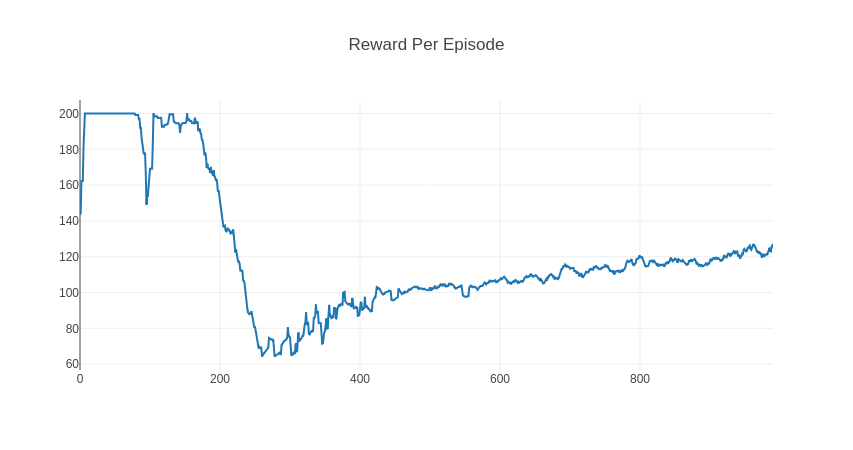

In [594]:
plotly.offline.iplot({
    "data": [go.Scatter(x=np.arange(len(ep_rewards)), y=moving_average(ep_rewards, 10))],
    "layout": go.Layout(title="Reward Per Episode")
})

In [ ]:
class SubEnvironment:
    def __init__(self, friction=None, lookback=8, max_steps=128, seed=None,
            noise=None, amplitude=None, frequency=None, period=None, phase=None,
            freq_var=None, amp_var=None):
        # cost of changing position
        self.fric_param = friction

        # how much of the value history the agent sees
        self.lookback = lookback

        # available actions (hold/invest)
        self.action_space = gym.spaces.Discrete(2)

        # how long an episode lasts
        self.max_steps = max_steps

        # noise to apply to the value
        self.noise_param = noise

        # max amplitude of value
        self.amp_param = amplitude

        # variance in amplitude
        self.amp_var_param = amp_var

        # frequency of value
        self.freq_param = frequency

        # variance in frequency
        self.freq_var_param = freq_var

        # period of value
        self.period_param = period

        # phase (t-offset) of value
        self.phase_param = phase

        # observation space (position + lookback)
        self.observation_space = gym.spaces.Box(low=-1., high=1.0,
                shape=(self.lookback + 1,), dtype=np.float32)

        # set a seed for testing
        self.seed = seed

    def handle_param(self, param, default=None):
        # frequency of value
        if param is None and default is not None:
            # default
            return default
        elif type(param) == tuple:
            # if a tuple is passed, a random value is picked in the range
            return (param[1] - param[0])*np.random.rand() + param[0]
        else:
            # we assume it's a number, and set it directly
            return float(param)


    def reset(self, seed=None):
        if seed is None:
            np.random.seed(self.seed)
        if seed:
            np.random.seed(seed)

        # The current timestep
        self.t = self.lookback

        # The rewards of the episode
        self.current_reward = 0.
        self.episode_rewards = [self.current_reward]

        # Our "time" space
        self.x_space = np.arange(self.max_steps)

        # Our "asset" space
        self.fric = self.handle_param(self.fric_param, 0.1)
        self.noise = self.handle_param(self.noise_param, 0)
        self.amp = self.handle_param(self.amp_param, 1.)
        self.amp_var = self.handle_param(self.amp_var_param, 0.)
        self.freq = self.handle_param(self.freq_param, 4)
        self.phase = self.handle_param(self.phase_param, 0)
        self.freq_var = self.handle_param(self.freq_var_param, 0)
        self.period = self.handle_param(self.period_param, self.max_steps)

        self.freq = self.period/self.freq
        self.a_space = np.array([])
        first = True
        while len(self.a_space) < self.max_steps:
            amp_var = 2*self.amp_var*np.random.rand() + (1 - self.amp_var)
            freq_var = 2*self.freq_var*np.random.rand() + (1 - self.freq_var)
            wave = np.sin(np.linspace(0, 2*np.pi, freq_var * self.freq, endpoint=False))
            wave *= amp_var
            if first:
                wave = wave[int(self.phase*len(wave)):]
                first = False
            self.a_space = np.concatenate([self.a_space, wave])

        self.a_space = self.a_space[:self.max_steps]
        self.a_space += np.random.normal(0, self.amp*self.noise, size=self.a_space.shape)

        # The current position of the agent (0: neutral, 1: long)
        self.position = 0

        # The current position (as a singleton) concatenated with
        # the current "viewable" observation
        self.observation = np.concatenate([[self.position], self.a_space[self.t-self.lookback+1:self.t+1]])

        return self.observation.reshape(self.observation_space.shape)

    def step(self, action):
        self.instantaneous_reward = 0
        # if we changed position...
        if self.position != action:
            # then we incur transaction costs
            self.instantaneous_reward -= self.fric*self.amp

            # and change our position
            self.position = action

        # increment time
        self.t += 1

        # update observation
        self.observation = np.concatenate([[self.position], self.a_space[self.t-self.lookback+1:self.t+1]])

        # our current asset value
        current = self.a_space[self.t]

        # the reward for our position
        # e.g., if our position == 0 (neutral), then we gain no reward
        # if our position == 1 (long), then we gain/lose the change
        self.instantaneous_reward += self.position * current
        self.current_reward += self.instantaneous_reward
        self.episode_rewards.append(self.current_reward)

        done = False
        if self.t >= self.max_steps - 1:
            done = True

        return self.observation.reshape(self.observation_space.shape), self.instantaneous_reward, done, {}

    def render(self):
        fig, ax = plt.subplots(1,2,figsize=(12,4),gridspec_kw = {'width_ratios':[2, 1]})

        ax[0].plot(self.x_space, self.a_space)
        ax[0].plot([self.t], [self.a_space[self.t]], 'o')
        ax[1].plot(self.episode_rewards)

        return fig

In [ ]:
ep_rewards = []
env = SubEnvironment()
a2c = ActorCriticModel(env.observation_space.shape[0], env.action_space.n)

for i in range(1000):
    print(f"Ep {i}")
    ep_rewards.append(run_v2(env, a2c, 1))

In [ ]:
plotly.offline.iplot({
    "data": [go.Scatter(x=np.arange(len(ep_rewards)), y=ep_rewards)],
    "layout": go.Layout(title="Reward Per Episode")
})